<a href="https://colab.research.google.com/github/AleAguirreM/LEA3_Health/blob/main/b_modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import joblib ### para cargar array
########Paquetes para NN #########
import tensorflow as tf
from sklearn import metrics ### para analizar modelo
from sklearn.ensemble import RandomForestClassifier  ### para analizar modelo
import pandas as pd
from sklearn import tree
import cv2 ### para leer imagenes jpeg
from matplotlib import pyplot as plt #

In [3]:
### cargar bases_procesadas ####
x_train = joblib.load('/content/drive/MyDrive/TB_Chest_Radiography_Database/salidas/x_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/TB_Chest_Radiography_Database/salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/TB_Chest_Radiography_Database/salidas/x_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/TB_Chest_Radiography_Database/salidas/y_test.pkl')

In [4]:
x_train.max()

255

In [5]:
x_test.max()

255

In [6]:
#### Escalar ######################
x_train = x_train.astype('float32') ## para poder escalarlo
x_test = x_test.astype('float32') ## para poder escalarlo
x_train /= 255 ### escalaro para que quede entre 0 y 1
x_test /= 255

###### verificar tamaños
print(x_train.shape)
x_test.shape

(3360, 100, 100, 3)


(840, 100, 100, 3)

In [7]:
np.product(x_train[1].shape) ## cantidad de variables por imagen

30000

In [8]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([2800,  560]))

In [9]:
np.unique(y_test, return_counts=True)

(array([0, 1]), array([700, 140]))

In [10]:
##### convertir a 1 d array ############
x_train2 = x_train.reshape(3360,30000)
x_test2 = x_test.reshape(840, 30000)
print(x_train2.shape)
x_test2.shape

(3360, 30000)


(840, 30000)

## Selección de indicador

El equilibrio entre identificar correctamente a los pacientes con neumonía y evitar que se escapen casos positivos es crucial para la eficacia de un modelo de diagnóstico. Si un modelo clasifica incorrectamente a muchos pacientes como negativos cuando en realidad tienen neumonía (falsos negativos), podría resultar en un tratamiento inadecuado o en la falta de tratamiento para esos pacientes, lo que puede tener consecuencias graves para su salud y aumentar los costos a largo plazo. Por otro lado, si el modelo clasifica incorrectamente a muchos pacientes como positivos cuando no tienen neumonía (falsos positivos), esto podría generar gastos innecesarios en pruebas adicionales o tratamientos, así como una carga adicional para el sistema de salud.

El AUC, al evaluar la capacidad del modelo para distinguir entre pacientes con neumonía y aquellos sin ella, ayuda a encontrar un equilibrio entre estos dos escenarios. Un AUC más alto indica que el modelo es mejor para discriminar entre casos positivos y negativos, lo que sugiere que se están minimizando tanto los falsos positivos como los falsos negativos. En otras palabras, un AUC alto indica que el modelo está clasificando correctamente a la mayoría de los pacientes con neumonía como positivos y a la mayoría de los pacientes sin neumonía como negativos, lo que reduce tanto los costos como los riesgos asociados con un diagnóstico incorrecto.


In [11]:
############################################################
################ Probar modelos de redes neuronales #########
############################################################

fc_model=tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=x_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [51]:
##### configura el optimizador y la función para optimizar ##############
fc_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy','AUC', 'Recall', 'Precision'])

#####Entrenar el modelo usando el optimizador y arquitectura definidas #########
fc_model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

#########Evaluar el modelo ####################
test_loss, test_acc, test_auc, test_recall, test_precision = fc_model.evaluate(x_test, y_test, verbose=2)
print("Test auc:", test_auc)

Epoch 1/10
34/34 [==============================] - 6s 122ms/step - loss: 0.1602 - accuracy: 0.9533 - auc: 0.9613 - recall: 0.8250 - precision: 0.8868 - val_loss: 0.1500 - val_accuracy: 0.9357 - val_auc: 0.9864 - val_recall: 0.6500 - val_precision: 0.9479
Epoch 2/10
34/34 [==============================] - 3s 77ms/step - loss: 0.0767 - accuracy: 0.9735 - auc: 0.9892 - recall: 0.9000 - precision: 0.9385 - val_loss: 0.1882 - val_accuracy: 0.9179 - val_auc: 0.9829 - val_recall: 0.5357 - val_precision: 0.9494
Epoch 3/10
34/34 [==============================] - 3s 80ms/step - loss: 0.0661 - accuracy: 0.9795 - auc: 0.9924 - recall: 0.9196 - precision: 0.9555 - val_loss: 0.0955 - val_accuracy: 0.9548 - val_auc: 0.9917 - val_recall: 0.9214 - val_precision: 0.8269
Epoch 4/10
34/34 [==============================] - 3s 84ms/step - loss: 0.1027 - accuracy: 0.9634 - auc: 0.9834 - recall: 0.8732 - precision: 0.9039 - val_loss: 0.1233 - val_accuracy: 0.9560 - val_auc: 0.9884 - val_recall: 0.7643 - v

Si bien la métrica AUC es crucial para evaluar el problema que estamos abordando, tanto en el conjunto de prueba como en el de test se observan buenos rendimientos. Además, no se han identificado problemas de subajuste (underfitting) ni de sobreajuste (overfitting), lo que sugiere que no será necesario implementar técnicas de regularización ni afinamiento de hiperparametros en este momento.

In [52]:
#ver la distribución de las probabilidades
import plotly.express as px
import pandas as pd
dis = fc_model.predict(x_test)
hist = px.histogram(dis)
hist.show()

27/27 [==============================] - 0s 9ms/step


El histograma de las probabilidades predichas nos permite tomar decisiones para realizar la clasificacion de los resultados.

* Si la probabilidad es mayor o igual al 60% el paciente se clasifica con Tuberculosis

* Si la probabilidad se ubica entre 30% y 60% se remite a un diagnostico por parte del personal medico

* Si la probabilidad es menor o igual al 30% el paciente se clasifica como Normal

27/27 [==============================] - 0s 14ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       700
           1       0.95      0.89      0.92       140

    accuracy                           0.97       840
   macro avg       0.96      0.94      0.95       840
weighted avg       0.97      0.97      0.97       840



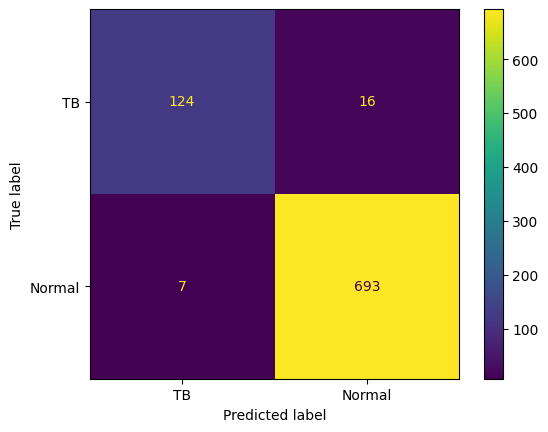

In [62]:
###### matriz de confusión test
pred_test=(fc_model.predict(x_test) > 0.60).astype('int')
cm=metrics.confusion_matrix(y_test,pred_test, labels=[1,0])
disp=metrics.ConfusionMatrixDisplay(cm,display_labels=['TB', 'Normal'])
disp.plot()

print(metrics.classification_report(y_test, pred_test))

Los resultados de la matriz son: 124 verdaderos positivos que tienen tuberculosis, 16 falsos positivos, 7 que son falsos negativos y 695 personas que no sufren de tuberculosis. El modelo tiene una alta precisión lo que indica que la mayoría de los casos clasificados como positivos son verdaderos. Además, el modelo es efectivo para capturar la mayoría de los casos positivos en los datos reales.

In [63]:
#################### exportar red ##############
# guardar modelo
fc_model.save('path_to_my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

